## This script uses VAR modeling on the multivariate time series per country

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

In [13]:
df_orig = pd.read_csv('.\Market_food_prices_w_temp_reduced.csv')
country_dict = dict(zip(df_orig.country_id,df_orig.country))
text_file1 = open(".\VAR_modeling_summary.doc", "w")

Calculate MAPE

In [14]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Fitting the model using VAR

In [15]:
def var_model(df_country,value,log):
    df_country['period'] = pd.to_datetime(df_country.period, format='%Y-%m-%d')
    df_country.set_index('period', inplace=True)

    df_trans = df_country.copy()

    #log transformation with differencing of 1
    if (log=='Y'):
        print('log transformation...')
        df_trans['avg_temp'] = np.log(df_trans.iloc[:, 1]).diff(1)
        df_trans['avg_temp_uncty'] = np.log(df_trans.iloc[:, 2]).diff(1)
        df_trans['price_in_USD'] = np.log(df_trans.iloc[:, 3]).diff(1)
        df_trans = df_trans.dropna()

    #get dynamic size of split based on time series
    init = int(len(df_trans) * 0.75) #get the 75% first
    if (init%12==0):          #check if it has the full year
        size = init
    else:
        size = int(init/12)*12 + 12 #calculate the next full year split

    train, valid = df_trans[0:size], df_trans[size:len(df_trans)]

    model = VAR(endog=train)
    model_fit = model.fit()
    print(model_fit.summary(), file=text_file1)
    model_fit.plot()
    model_fit.plot_acorr()

    plt.title("VAR model", fontsize=20)
    fig = plt.gcf()
    fig.savefig('./plot-var-model/'+ value + '-var.png')

    cols = train.columns
    prediction = model_fit.forecast(model_fit.y, steps=len(valid))

    #converting predictions to dataframe
    pred = pd.DataFrame(index=range(0, len(prediction)), columns=[cols])
    for j in range(0, 3):
        for i in range(0, len(prediction)):
            pred.iloc[i][j] = prediction[i][j]

    #check rmse, mae, mape
    for i in cols:
        print('RMSE value for', i, 'is : ', sqrt(mean_squared_error(pred[i], valid[i])), file=text_file1)
        print('MAE value for', i, 'is : ', mean_absolute_error(pred[i], valid[i]), file=text_file1)
        print('MAPE value for', i, 'is : ', mean_absolute_percentage_error(pred[i], valid[i]), file=text_file1)

C:\Users\Janelle\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Janelle\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Janelle\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Janelle\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information a

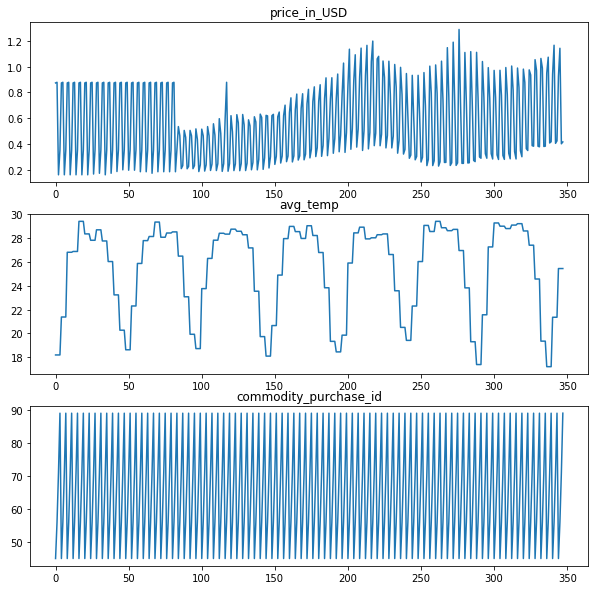

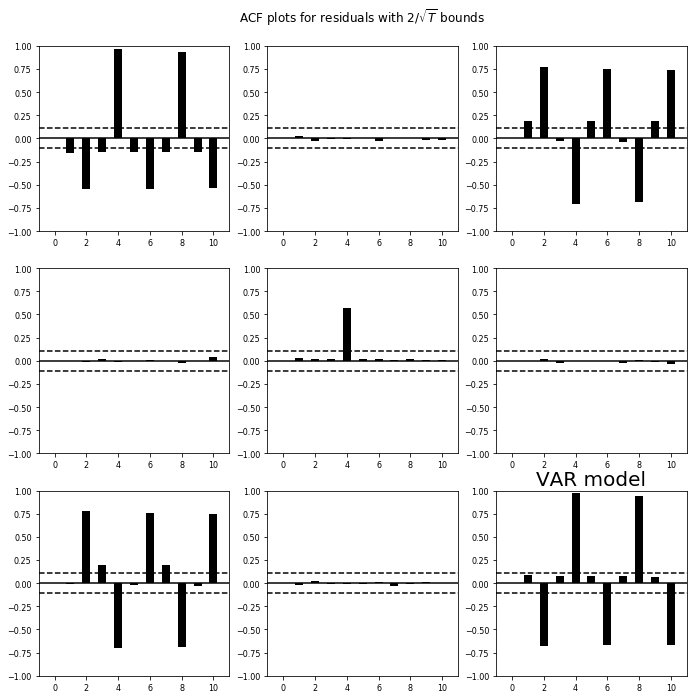

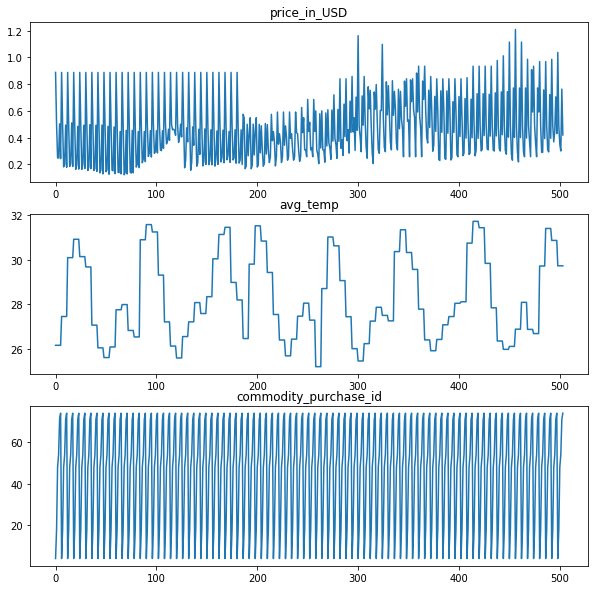

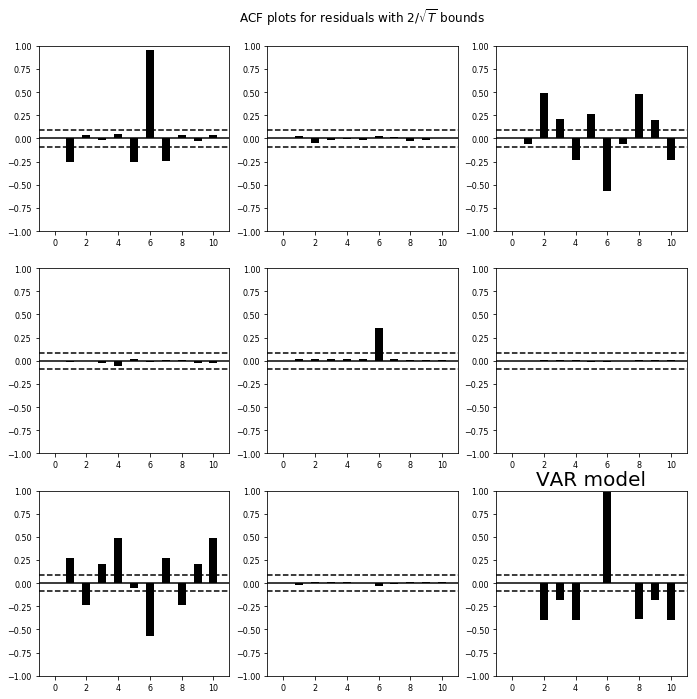

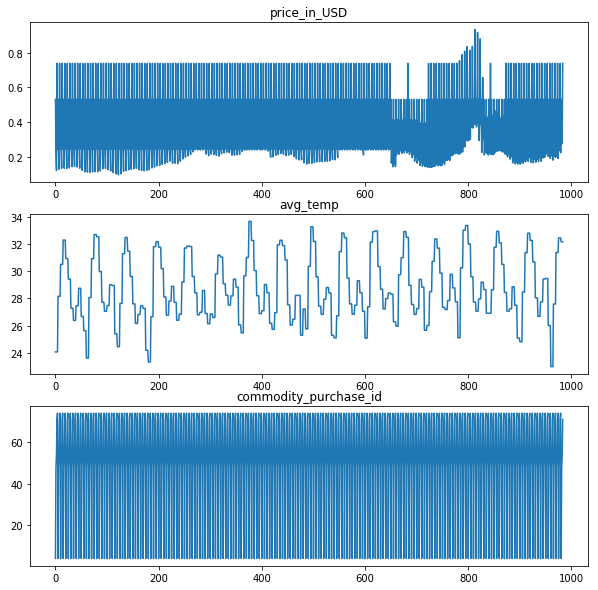

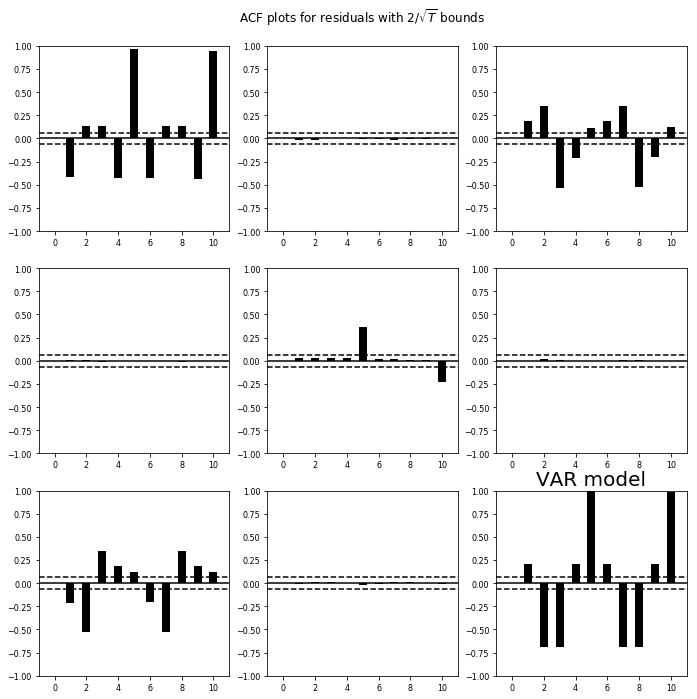

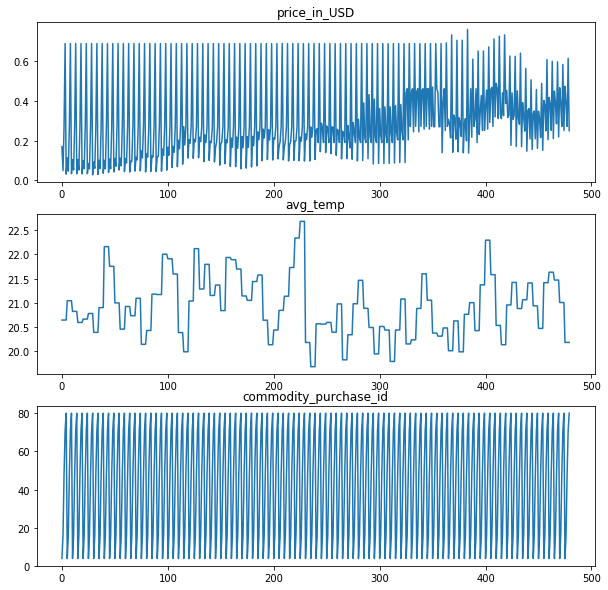

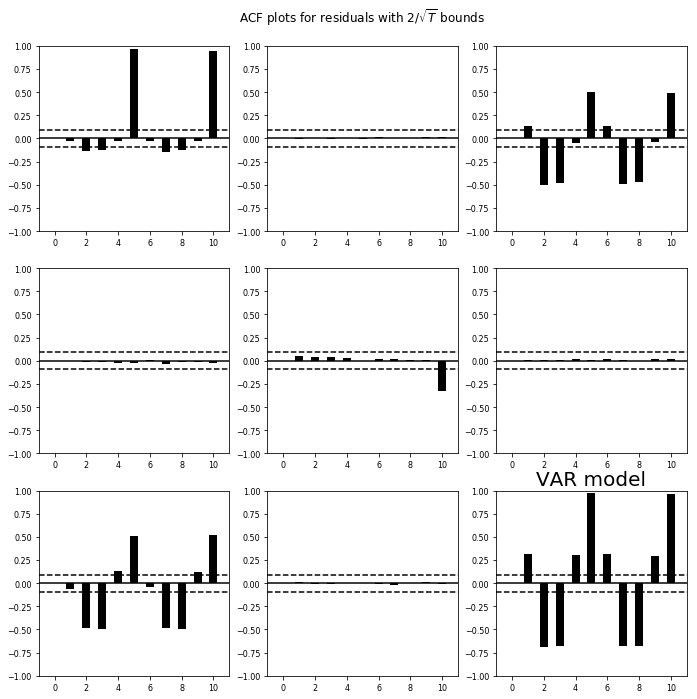

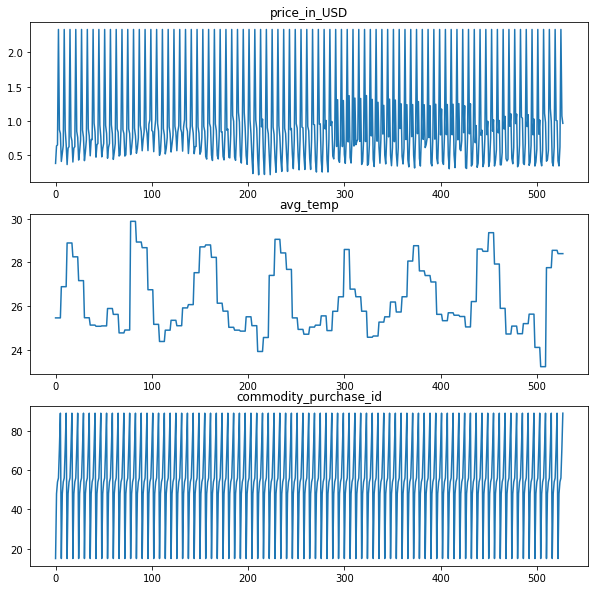

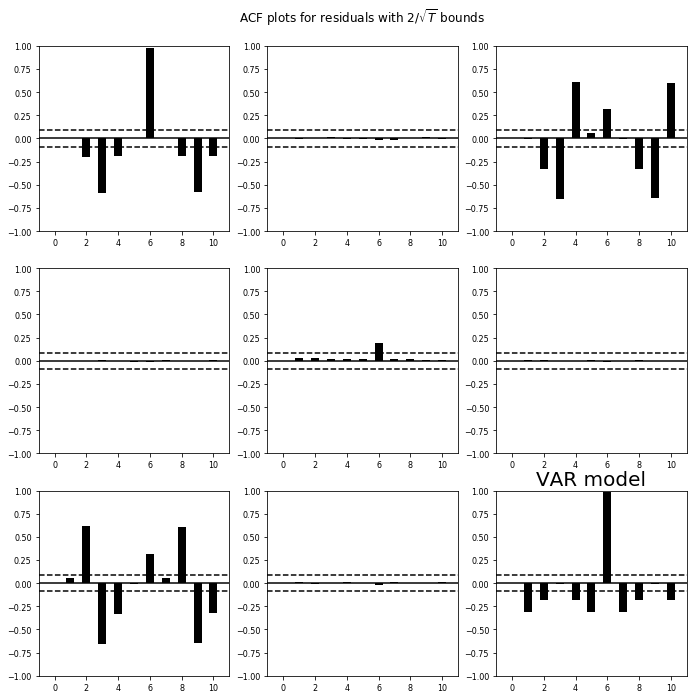

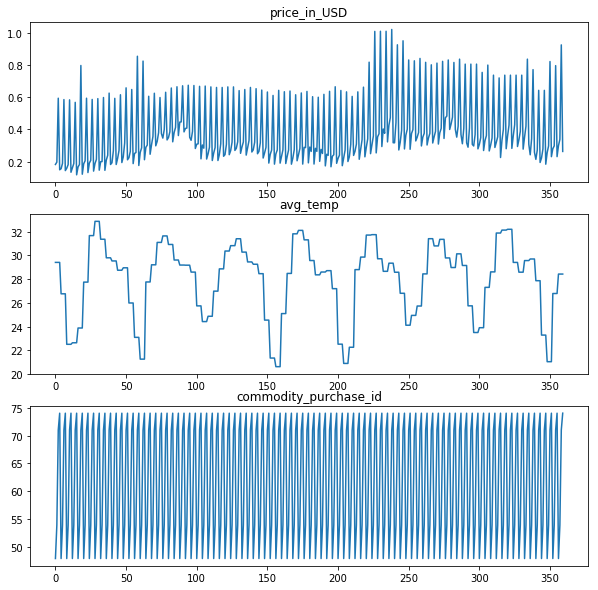

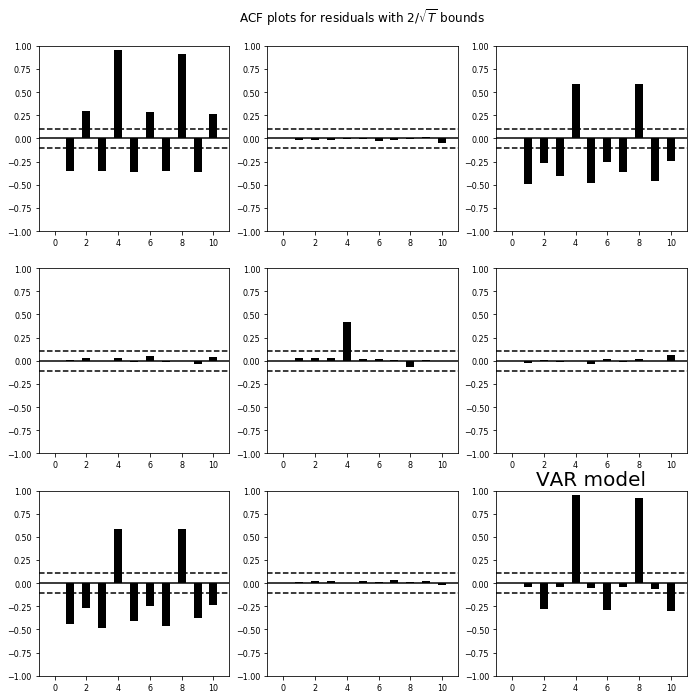

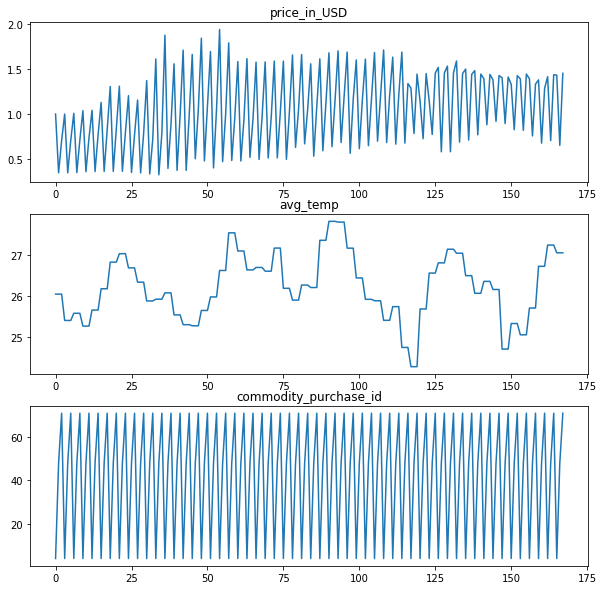

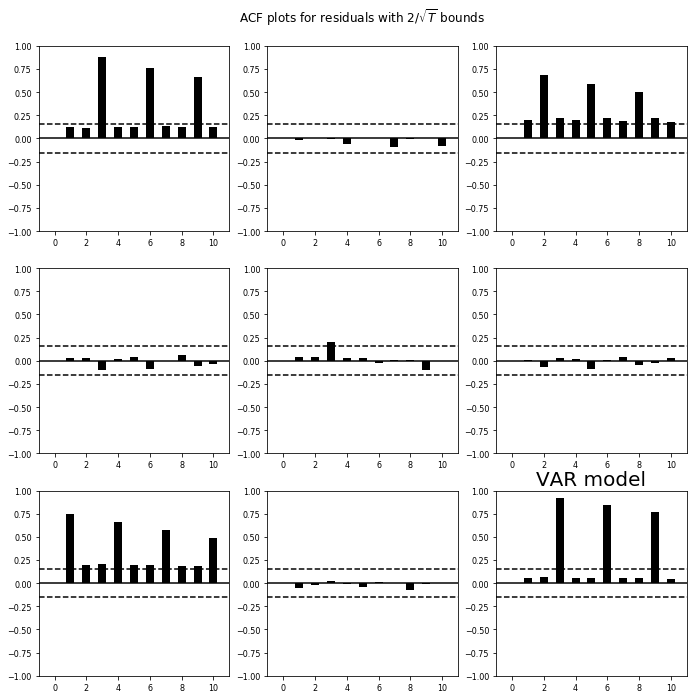

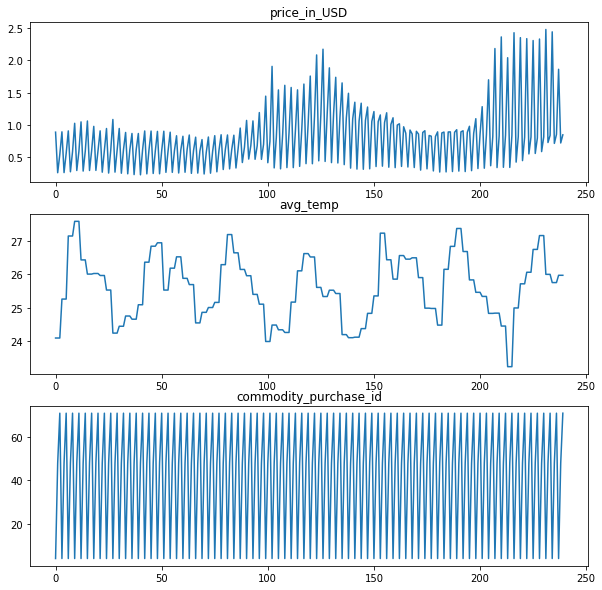

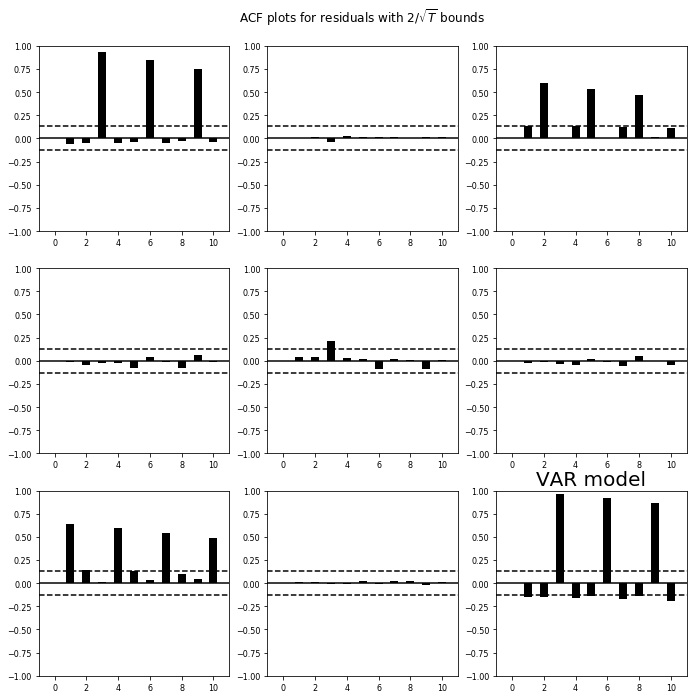

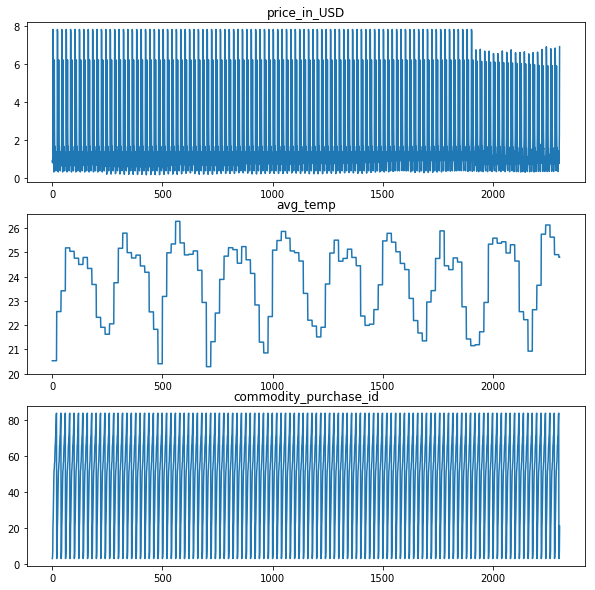

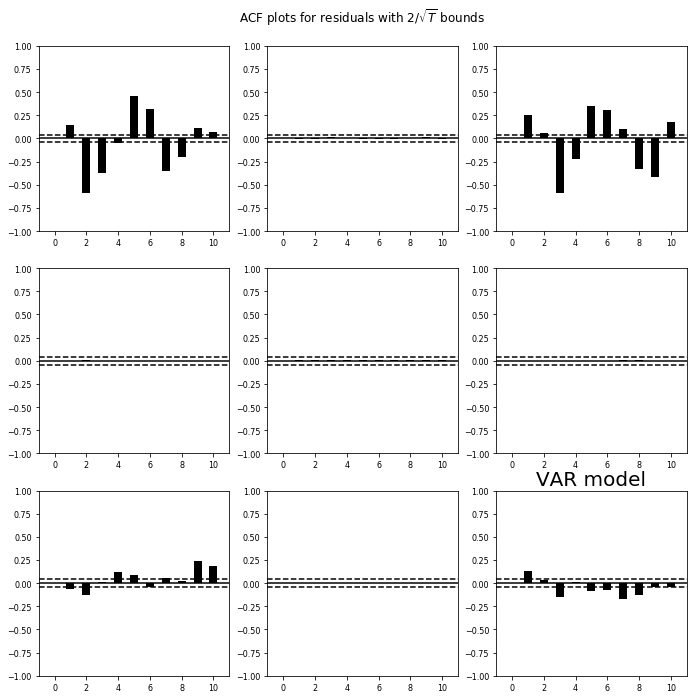

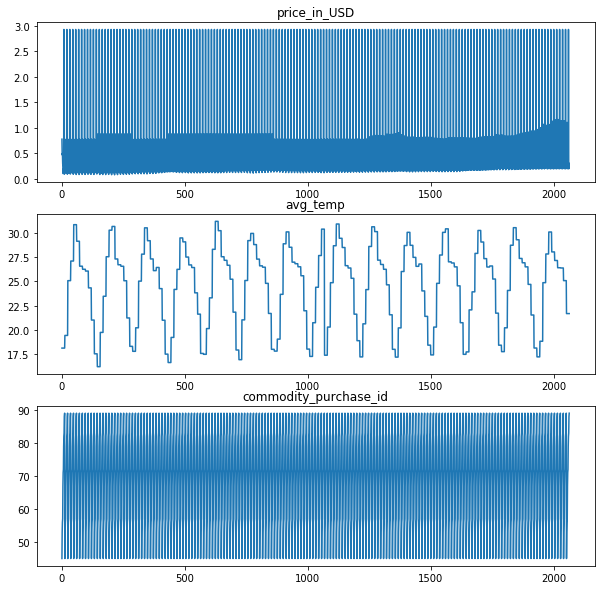

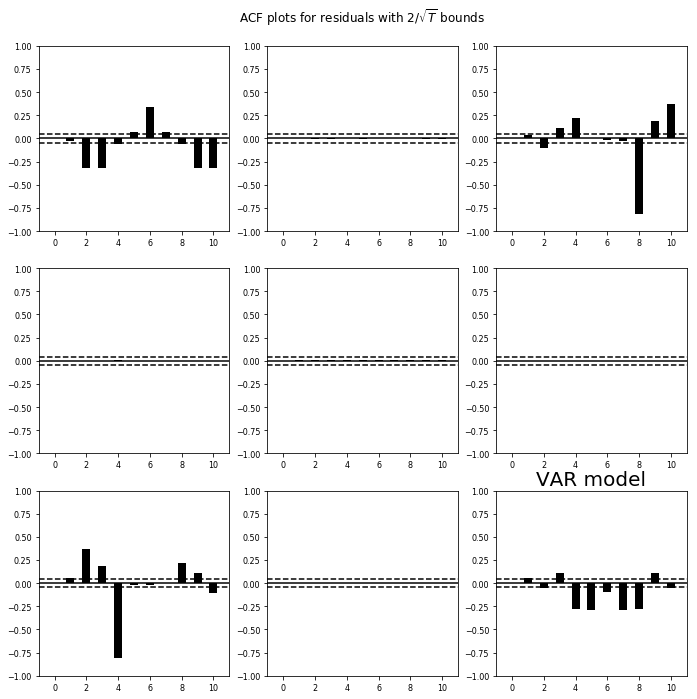

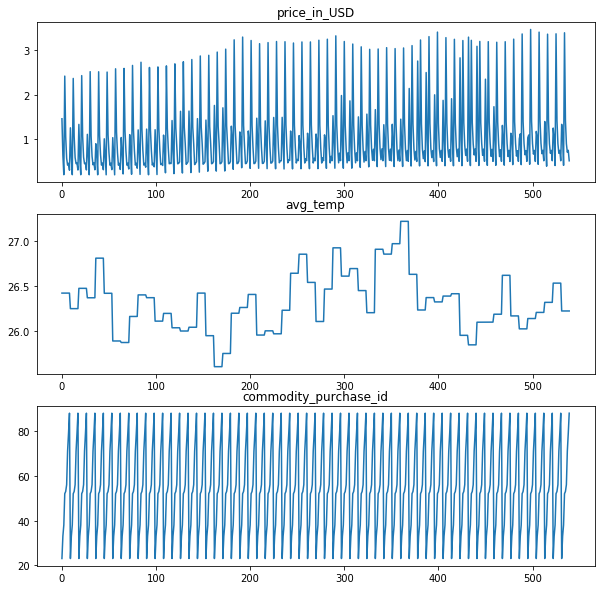

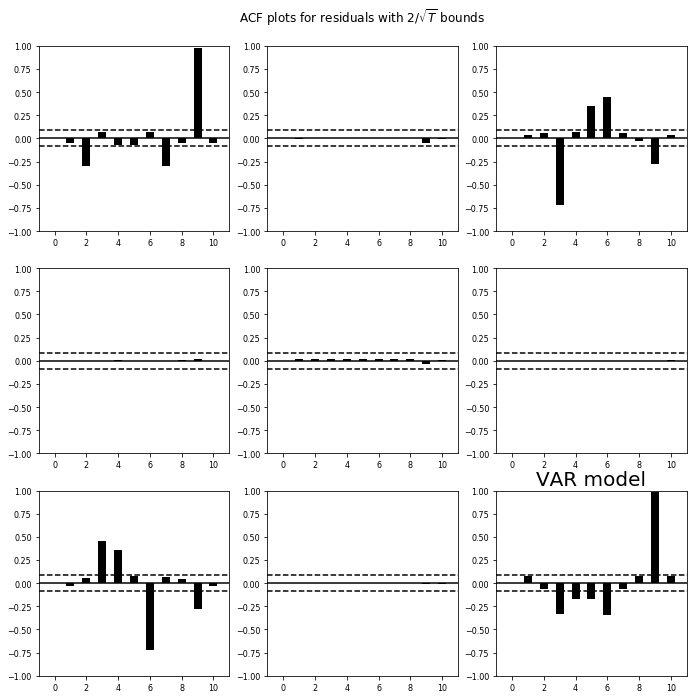

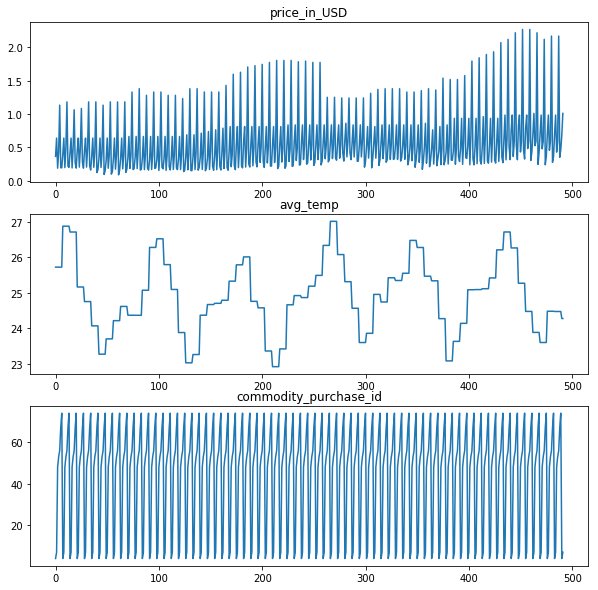

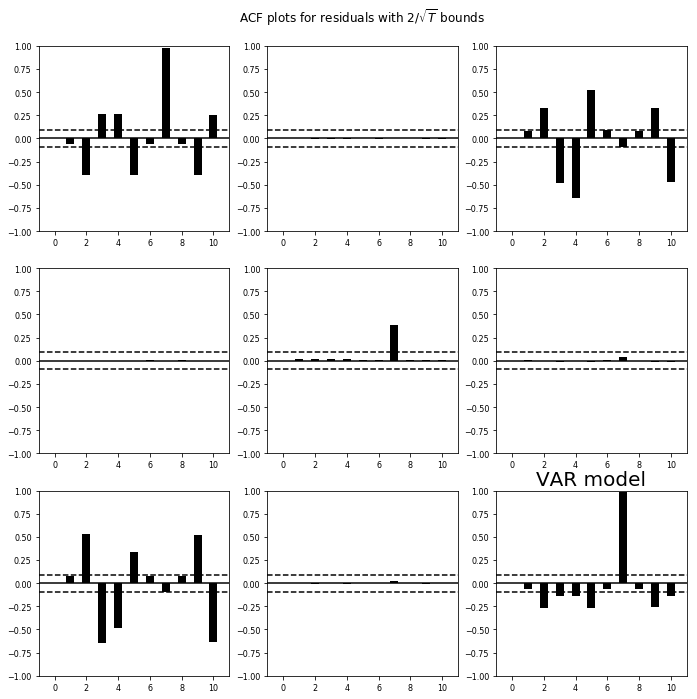

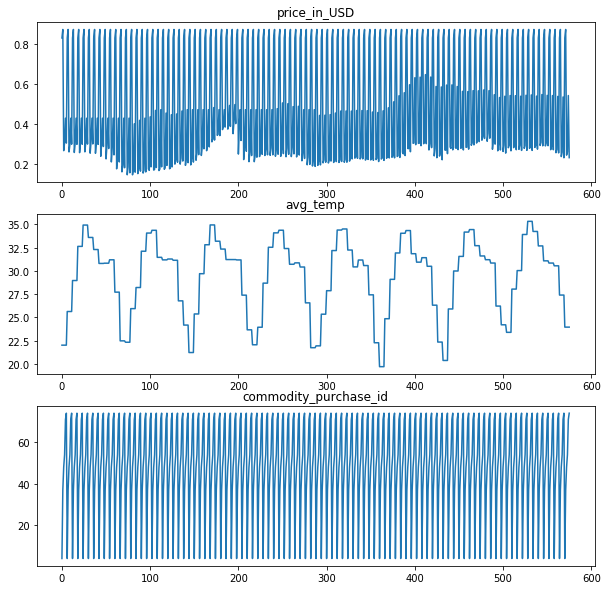

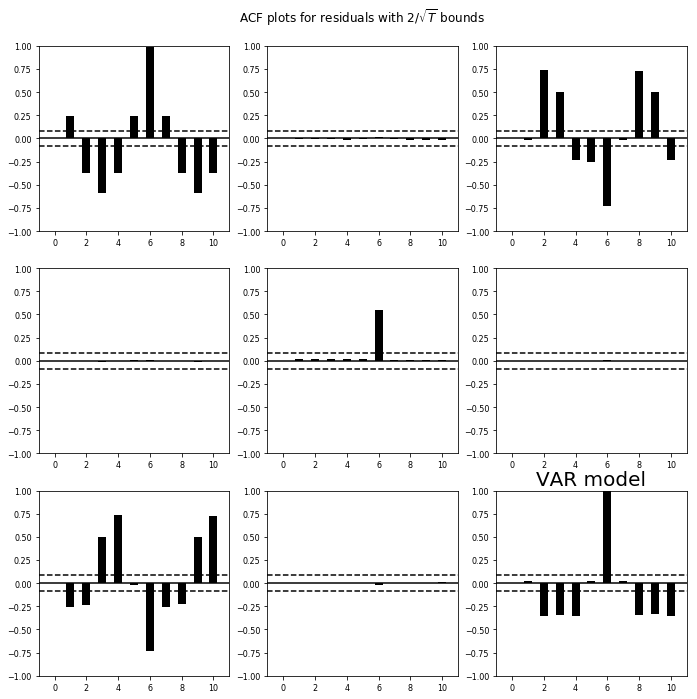

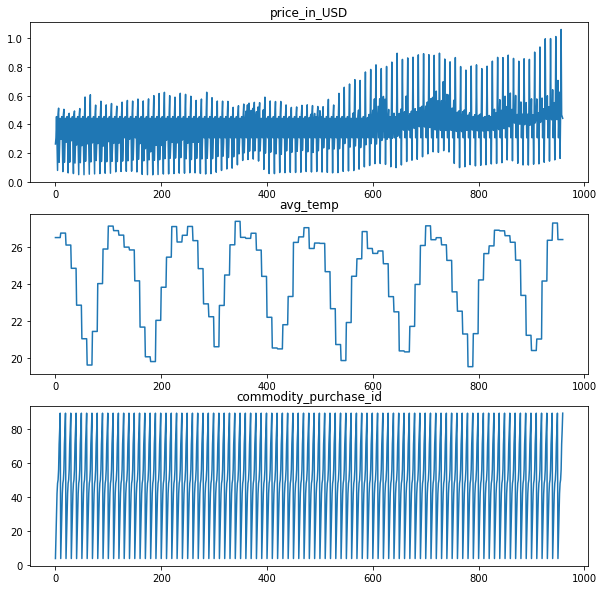

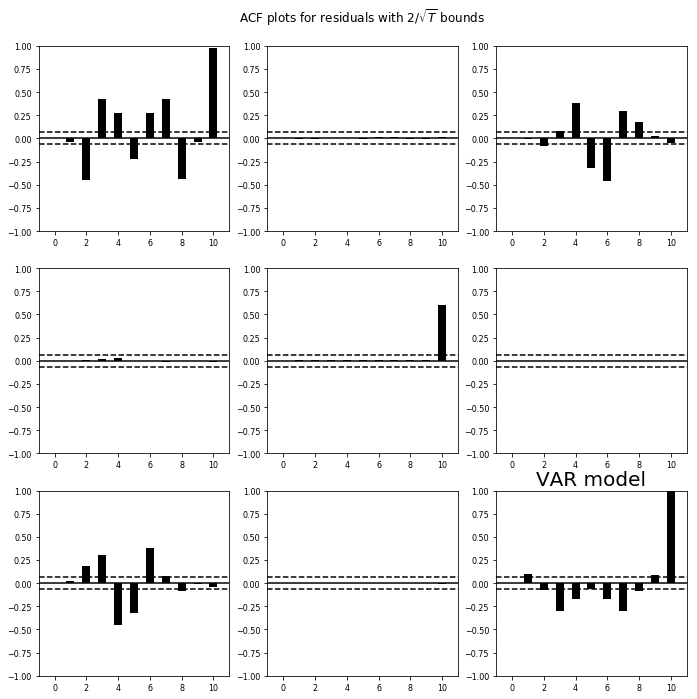

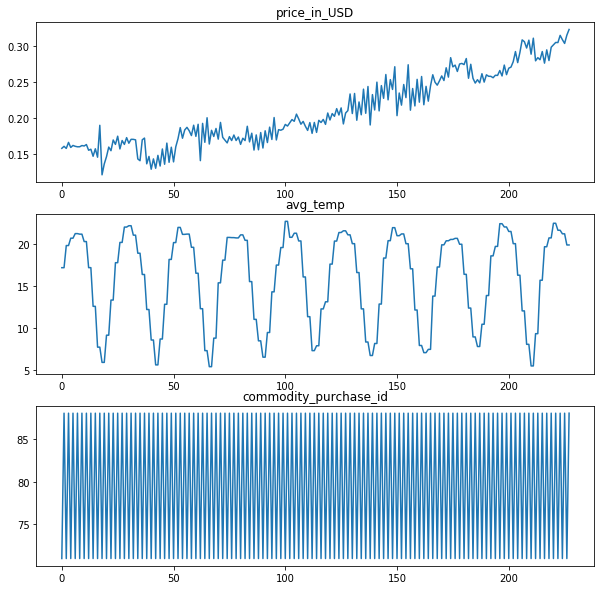

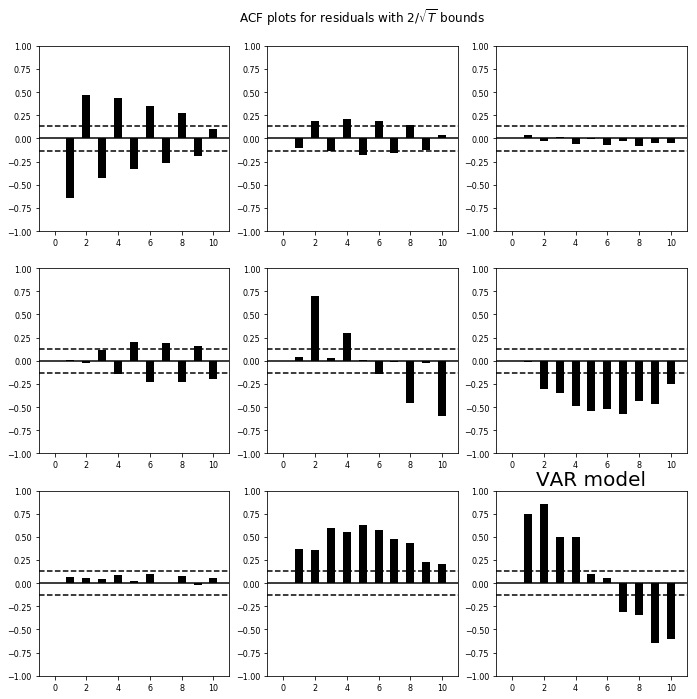

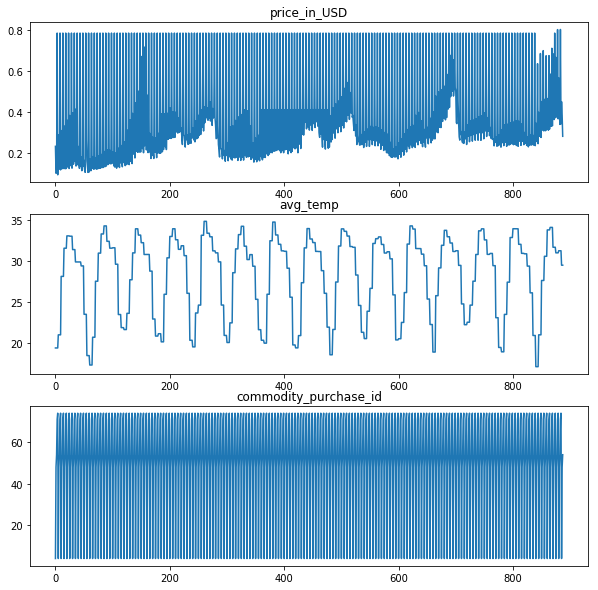

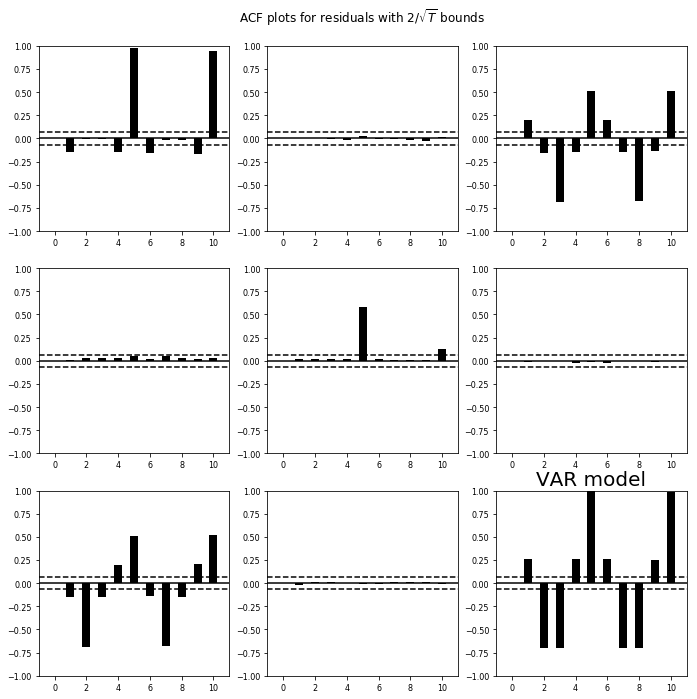

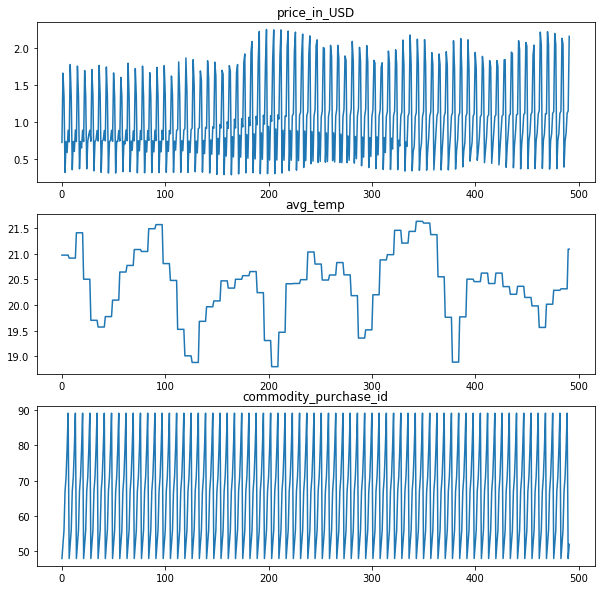

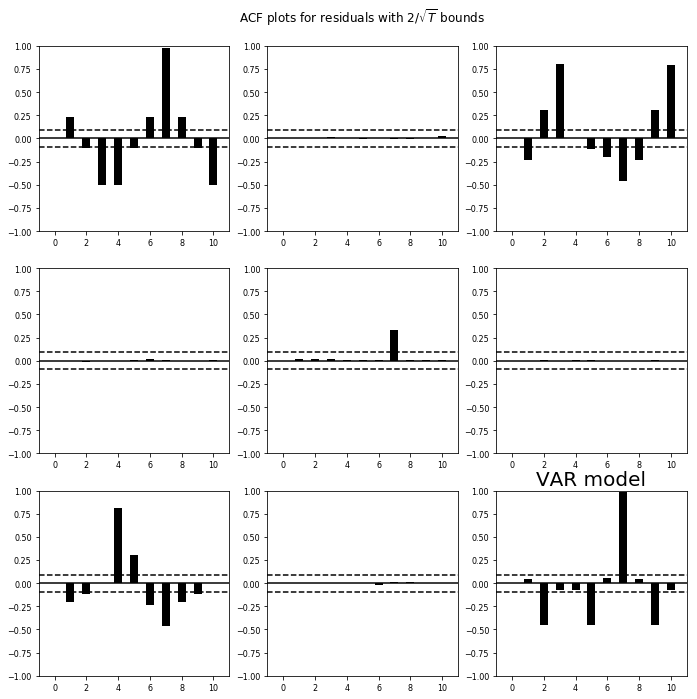

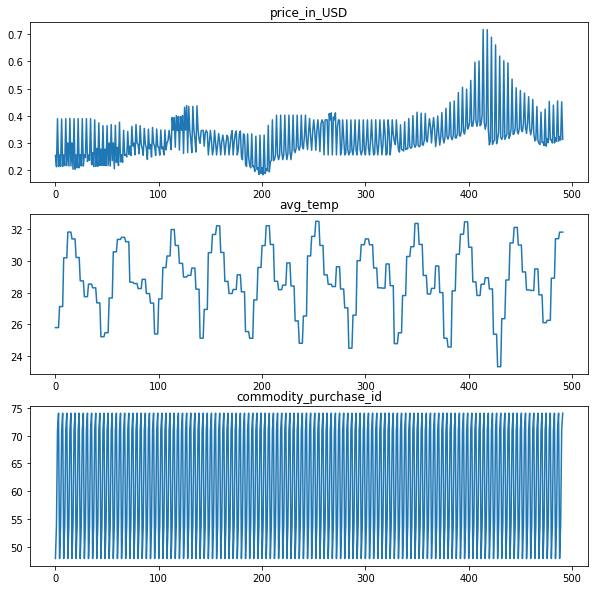

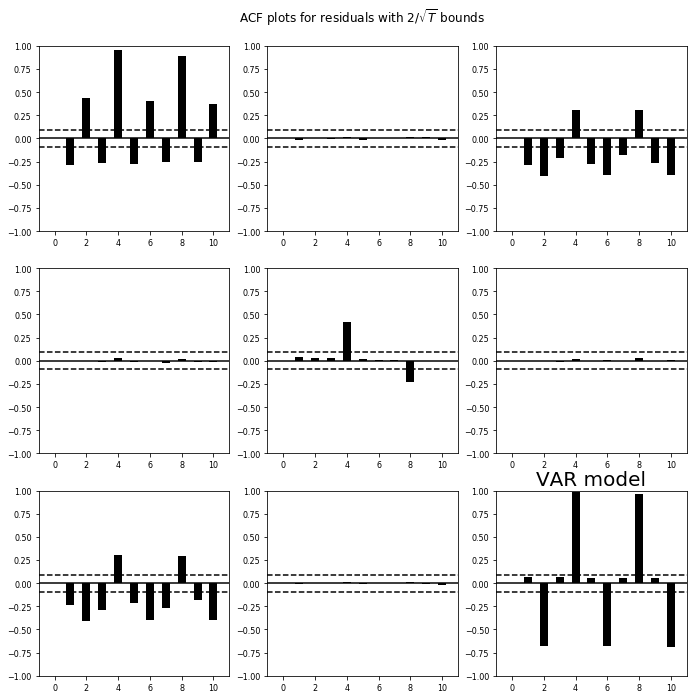

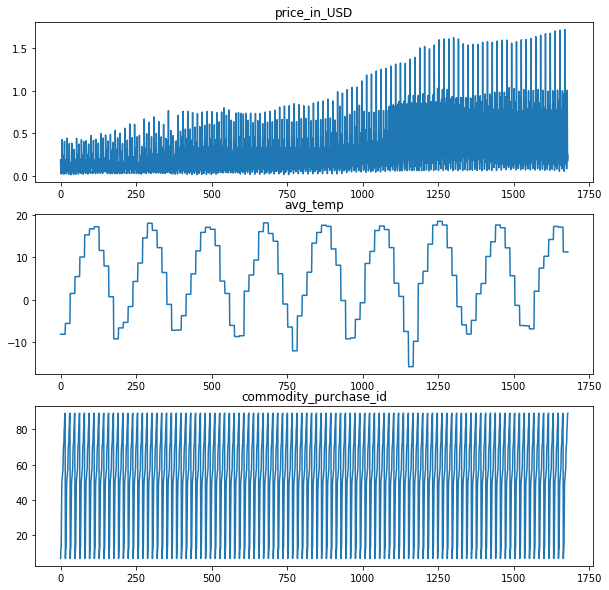

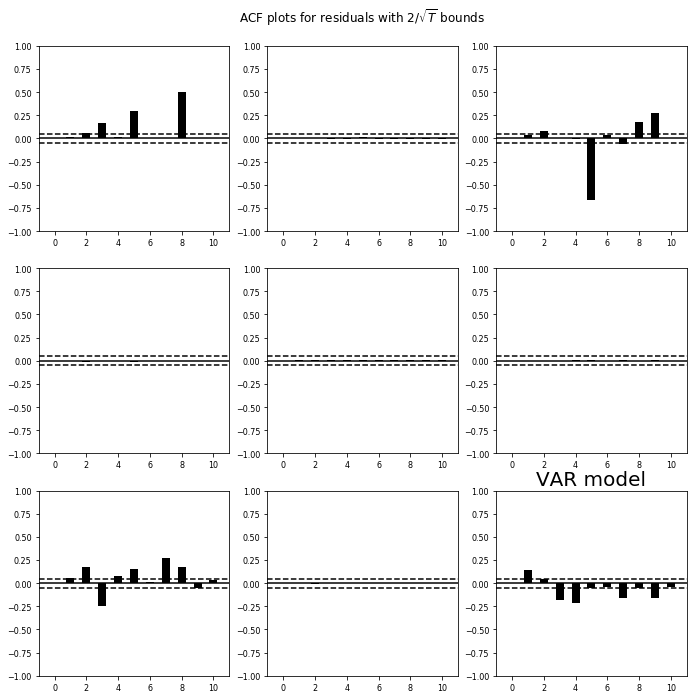

In [16]:
for key, value in country_dict.items():
    df_country = pd.read_csv('.\countries\country_df_'+ value +'.csv')
    df_country.sort_values(by='period')
    df_country['period'] = pd.to_datetime(df_country.period, format='%Y-%m-%d')
    drop_cols = ['country_id', 'country', 'commodity_purchased']
    df_country.drop(drop_cols, axis=1, inplace=True)
    print('='*70, file=text_file1)
    print(str(value), file=text_file1)
    print('=' * 70, file=text_file1)
    var_model(df_country, value, 'N')#df, country name, if log=Y, then perform log transformation and differencing
